# Waste Classification

# 1. Create CSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Buat CSV secara otomatis berdasarkan folder Google Drive yang telah berisi gambar yang telah diklasifikasikan dengan kolom CSV berisi filepath dan class

In [ ]:
import os
import csv

dataset_path = '/content/drive/MyDrive/ColabNotebooks/Praktikum_ML/UAS_Waste_Classification/dataset'
csv_file = 'waste.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["filepath", "class"])

    # Check if the dataset path exists
    if not os.path.exists(dataset_path):
        print(f"Dataset path '{dataset_path}' does not exist.")
        exit()

    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)

        # Check if the split path is a directory
        if not os.path.isdir(split_path):
            print(f"'{split_path}' is not a directory.")
            continue

        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)

            # Check if the class path is a directory
            if not os.path.isdir(class_path):
                print(f"'{class_path}' is not a directory.")
                continue

            print(f"Processing class: {class_name} in {split} set")

            for image_name in os.listdir(class_path):
                # Check for valid image extensions
                if image_name.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(class_path, image_name)
                    print(f"Processing image: {image_path}")
                    writer.writerow([image_path, class_name])
                else:
                    print(f"Skipped file (not an image): {image_name}")

print("CSV file created successfully.")


# 2. Import

In [ ]:
import os
import numpy as np
import pandas as pd
import PIL
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import InceptionV3

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Praktikum_ML/UAS_Waste_Classification/waste.csv')
df.head()

,filepath,class
0,/content/drive/MyDrive/ColabNotebooks/Praktiku...,organik
1,/content/drive/MyDrive/ColabNotebooks/Praktiku...,organik
2,/content/drive/MyDrive/ColabNotebooks/Praktiku...,organik
3,/content/drive/MyDrive/ColabNotebooks/Praktiku...,organik
4,/content/drive/MyDrive/ColabNotebooks/Praktiku...,organik


# 3. Data Preprocessing

In [ ]:
# Paths
INPUT_DIR = '/content/drive/MyDrive/ColabNotebooks/Praktikum_ML/UAS_Waste_Classification/dataset'

TRAIN_DIR = '/content/drive/MyDrive/ColabNotebooks/Praktikum_ML/UAS_Waste_Classification/dataset/train'
TEST_DIR = '/content/drive/MyDrive/ColabNotebooks/Praktikum_ML/UAS_Waste_Classification/dataset/test'

DIMS = (224,224)
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

In [ ]:
# Membuat Image Augmentation Rescaling pada dataset

data_gen = ImageDataGenerator(
    rescale=1/255,         # Normalize gambar
    rotation_range=40,     # Rotasi gambar 40 derajat
    width_shift_range=0.2, # Geser gambar secara horizontal
    height_shift_range=0.2,# Geser gambar secara vertikal
    shear_range=0.2,       # Geser gambar secara acak
    zoom_range=0.2,        # Zoom gambar hingga 20%
    horizontal_flip=True,  # Balik gambar secara horizontal
    fill_mode='nearest'    # Isi pixel yang hilang setelah augmentasi dengan nilai pixel terdekat
)

In [ ]:
# Menerapkan Image Augmentation pada train dan test

train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TRAIN_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TEST_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

Found 150 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [ ]:
# Mengubah index array dari class menjadi nama saat ditampilkan hasilnya nanti

label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['anorganik', 'b3', 'organik'], dtype='<U9')

In [ ]:
# Mendefinisikan dimensi gambar yang akan diterima model yakni 224x224 pixel dan 3 warna yakni RGB
IMG_SHAPE = (224,224,3)

# Memuat pre-trained model Inception V3
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=3)

87910968/87910968 [==============================] - 0s 0us/step


# 4. Model Training

In [ ]:
# Arsitektur model

base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(100,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22007987 (83.95 MB)
Trainable params: 205203 (801.57 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# Callbacks
# Mengurangi Learning Rate sebanyak 0.1 % jika loss tidak membaik dalam 5 epoch berturut-turut
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.001)

# Memberhentikan training jika loss tidak membaik dalam 10 epoch berturut-turut
es = EarlyStopping(monitor='loss', verbose=2, patience=10, min_delta=0.001)

In [ ]:
# Training Model

logs = model.fit(train_data,
                 steps_per_epoch=train_data.samples // BATCH_SIZE,
                 validation_data=test_data,
                 validation_steps=test_data.samples // BATCH_SIZE,
                 epochs=25,
                 verbose=1,
                 callbacks=[reduce_lr, es])

Epoch 1/25
4/4 [==============================] - 94s 25s/step - loss: 19.2814 - accuracy: 0.3983 - val_loss: 13.9700 - val_accuracy: 0.4375 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - 6s 2s/step - loss: 10.5590 - accuracy: 0.3220 - val_loss: 7.6697 - val_accuracy: 0.4844 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - 5s 1s/step - loss: 6.0600 - accuracy: 0.4746 - val_loss: 0.4182 - val_accuracy: 0.9062 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - 7s 2s/step - loss: 1.7607 - accuracy: 0.6484 - val_loss: 2.3063 - val_accuracy: 0.6094 - lr: 0.0100
Epoch 5/25
4/4 [==============================] - 6s 2s/step - loss: 0.5316 - accuracy: 0.8559 - val_loss: 0.2657 - val_accuracy: 0.8906 - lr: 0.0100
Epoch 6/25
4/4 [==============================] - 5s 2s/step - loss: 0.7387 - accuracy: 0.8051 - val_loss: 0.2996 - val_accuracy: 0.8906 - lr: 0.0100
Epoch 7/25
4/4 [==============================] - 7s 2s/step - loss: 0.2194 - accuracy: 0.9153 

# 5. Data Visualization

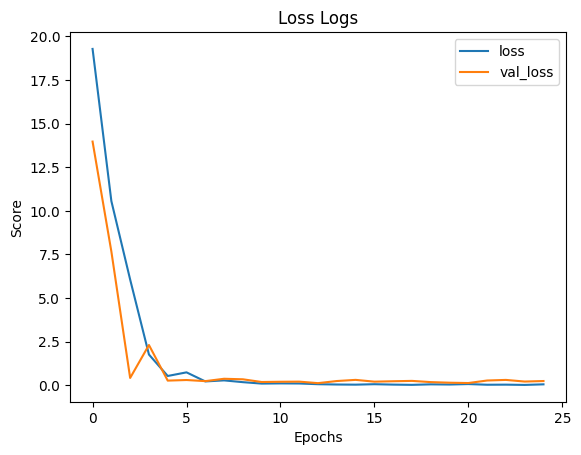

In [ ]:
# Visualisasi Loss

plt.plot(logs.history['loss'], label='loss')
plt.plot(logs.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Loss Logs')
plt.show()

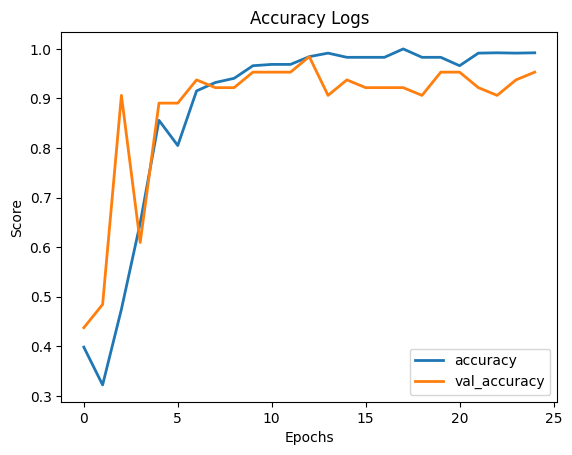

In [ ]:
# Visualisasi Akurasi

plt.plot(logs.history['accuracy'], label='accuracy', linewidth=2)
plt.plot(logs.history['val_accuracy'], label='val_accuracy', linewidth=2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Accuracy Logs')
plt.show()

# 6. Model Evaluation

Akurasi model sekitar 94%

In [ ]:
model.evaluate(test_data)

3/3 [==============================] - 4s 1s/step - loss: 0.1923 - accuracy: 0.9467


[0.19231167435646057, 0.9466666579246521]

Menyimpan model yang telah di-train

In [ ]:
# simpan model
model.save('waste-classification-model-v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 7. Model Prediction

Contoh penggunaan model dalam klasifikasi gambar

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/ColabNotebooks/Praktikum_ML/UAS_Waste_Classification/waste-classification-model-v2.h5')

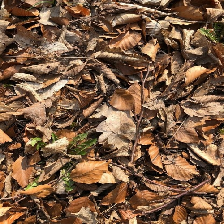

1/1 [==============================] - 0s 122ms/step
Predicted Label: organik
Probability: 0.9956914782524109


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import requests
from io import BytesIO

DIMS = (224, 224)

# Konversi ke array agar dapat diproses model Keras dan normalisasi input gambar
def predictor(img):
    display(img)
    arr = img_to_array(img)
    arr = arr / 255.0
    arr = np.expand_dims(arr, 0)
    res = model.predict(arr)
    idx = np.argmax(res)
    label = label_mapper[idx]

    return label, res[0][idx]

# Masukkan path file dari colab
img_path = '/content/drive/MyDrive/ColabNotebooks/Praktikum_ML/UAS_Waste_Classification/eksperimen/daun.jpg'

img = load_img(img_path, target_size=DIMS)

predicted_label, probability = predictor(img)

print(f'Predicted Label: {predicted_label}')
print(f'Probability: {probability}')
